In [1]:
import pennylane as qml
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import sys
import os
import pickle

sys.path.append(os.path.abspath('..'))
from src.utils import *

import warnings
warnings.filterwarnings('ignore')

## 2.1 Geração do Dataset Make Moons

Dataset clássico não-linear para classificação binária.

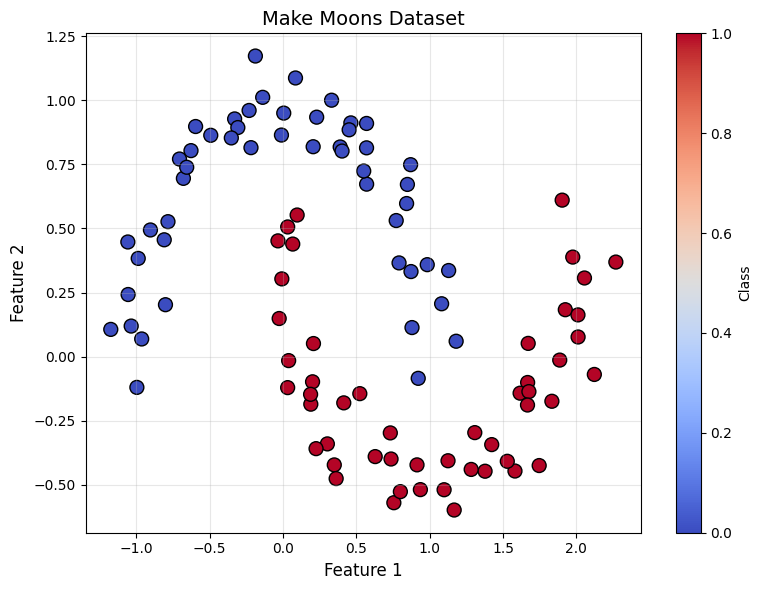

Dataset shape: (100, 2)
Classes distribution: [50 50]


In [2]:
# Gerar make_moons
X, y = make_moons(n_samples=100, noise=0.1, random_state=42)

# plot the dataset
plot_dataset(X, y, title='Make Moons Dataset')

print(f"Dataset shape: {X.shape}")
print(f"Classes distribution: {np.bincount(y)}")

### Por que Make Moons?

<!-- TODO: Explicar características -->
<!-- - Não-linearidade clara -->
<!-- - 2D (fácil de visualizar) -->
<!-- - Problema realista mas simples -->

## 2.2 Normalização dos Dados

Training set size: 80
Test set size: 20
Training classes: [40 40]
Test classes: [10 10]


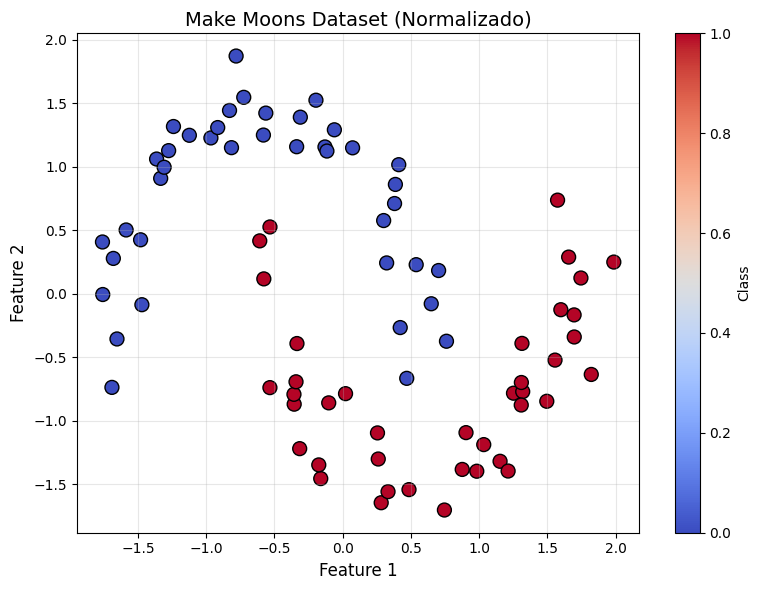

In [3]:
# Normalizar usando StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split treino/teste (80% treino, 20% teste)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)
    
print(f"Training set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")
print(f"Training classes: {np.bincount(y_train)}")
print(f"Test classes: {np.bincount(y_test)}")

# Visualizar dados normalizados
plot_dataset(X_train, y_train, title='Make Moons Dataset (Normalizado)')

## 2.3 Angle Embedding

Transformação de dados clássicos em rotações de qubits.

In [4]:
# Número de qubits
n_qubits = 2

# Testar angle embedding
test_point = X_train[0]
state = Angle_embedding(test_point, n_qubits)
print(f"Ponto de teste: {test_point}")
print(f"Estado quântico (2 primeiros componentes): {state[:2]}")

Ponto de teste: [-1.58675518  0.50123233]
Estado quântico (2 primeiros componentes): [0.67952883+0.j 0.17395827+0.j]


### Como funciona o Angle Embedding?

**Processo de codificação:**
- **Cada feature → rotação RY**: Feature 1 → RY no qubit 0, Feature 2 → RY no qubit 1
- **2 features → 2 qubits**: Dimensão do problema define número de qubits
- **Por que angle encoding?**: 
  - Simples e eficiente
  - Preserva informação contínua dos dados
  - Compatível com gradientes quânticos
  - Funciona bem para dados normalizados

**Matematicamente**: `RY(x₁)|0⟩ ⊗ RY(x₂)|0⟩`

## 2.4 Ansatz Variacional

Circuito parametrizado que será treinado.

In [5]:
# Definir número de camadas
n_layers = 2

# Criar circuito variacional para teste
variational_circuit = create_variational_circuit(n_qubits, n_layers)

# Testar circuito
dummy_params = np.random.uniform(0, 2*np.pi, (n_layers, n_qubits, 3))
dummy_x = X_train[0]
result = variational_circuit(dummy_params, dummy_x)

print(f"Teste do circuito (usando utils.create_variational_circuit):")
print(f"Input: {dummy_x}")
print(f"Output: {result:.4f}")

Teste do circuito (usando utils.create_variational_circuit):
Input: [-1.58675518  0.50123233]
Output: 0.4040


### Design do Ansatz

**Justificativas arquiteturais:**

- **Por que 2 layers?** 
  - Suficiente expressividade para make_moons
  - Evita barren plateaus (gradientes que desaparecem)
  - Tempo de execução razoável

- **Por que Rot gates?** 
  - Rotação geral (3 parâmetros por qubit)
  - Cobre todas as rotações no espaço de Bloch
  - Máxima flexibilidade

- **Por que CNOT?** 
  - Cria entanglement entre qubits
  - Gate padrão em hardware quântico
  - Captura correlações entre features

- **Evitar barren plateau:**
  - Circuito raso (2 layers)
  - Inicialização em [0, 2π]
  - 12 parâmetros total (controlado)

## 2.5 Visualização do Circuito

Quantum Circuit Architecture:
0: ─╭AngleEmbedding(M0)──Rot(1.27,0.71,5.31)─╭X──Rot(0.23,1.01,2.91)─╭X─┤  <Z>
1: ─╰AngleEmbedding(M0)──Rot(0.78,3.42,0.94)─╰●──Rot(1.28,3.47,0.33)─╰●─┤     

M0 = 
[0.5 0.5]


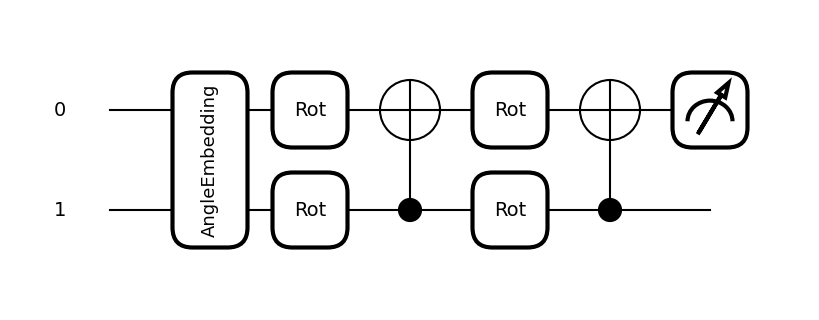

INFORMAÇÕES DO CIRCUITO
Qubits: 2
Layers: 2
Parâmetros treináveis: 12
Gates por layer: 2 Rot + 1 CNOT
Total de gates: 6


In [6]:
# Desenhar circuito
dummy_params = np.random.uniform(0, 2*np.pi, (n_layers, n_qubits, 3))
dummy_x = np.array([0.5, 0.5])

print("Quantum Circuit Architecture:")
print(qml.draw(variational_circuit)(dummy_params, dummy_x))

# Desenhar visualmente com matplotlib
try:
    fig, ax = qml.draw_mpl(variational_circuit)(dummy_params, dummy_x)
    plt.tight_layout()
    os.makedirs('../figures', exist_ok=True)
    plt.savefig('../figures/quantum_circuit_diagram.png', dpi=300, bbox_inches='tight')
    plt.show()
except Exception as e:
    print(f"\nVisualização gráfica não disponível ({e})")

# Informações do circuito
print(f"INFORMAÇÕES DO CIRCUITO")
print(f"Qubits: {n_qubits}")
print(f"Layers: {n_layers}")
print(f"Parâmetros treináveis: {n_layers * n_qubits * 3}")
print(f"Gates por layer: {n_qubits} Rot + 1 CNOT")
print(f"Total de gates: {n_layers * (n_qubits + 1)}")

## 2.6 Salvar Dados Processados

In [7]:
# Criar diretórios
os.makedirs('../data', exist_ok=True)
os.makedirs('../figures', exist_ok=True)

# Salvar dados
np.save('../data/X_train.npy', X_train)
np.save('../data/X_test.npy', X_test)
np.save('../data/y_train.npy', y_train)
np.save('../data/y_test.npy', y_test)

# Salvar scaler e config
with open('../data/scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

circuit_config = {
    'n_qubits': n_qubits,
    'n_layers': n_layers,
    'total_params': n_layers * n_qubits * 3
}
np.save('../data/circuit_config.npy', circuit_config)

## Checklist

- [x] Dataset make_moons gerado e visualizado
- [x] Dados normalizados e divididos (treino/teste)
- [x] Angle embedding implementado
- [x] Ansatz variacional construído
- [x] Circuito visualizado (diagram)
- [x] Dados salvos para próximas etapas
